# AUTOMATED CLASSIFICATION OF MOVIES FROM THEIR SCRIPTS
# Data Analysis and Models

The dataframe from data source and cleaning notebook will be imported here and used for building the models for prediction. 

This was done to avoid errors that might arise when scrapping the script tags online.

In [1]:
#Import all libraries needed

import os
import warnings
import requests
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn
import nltk
import re
import json
import string
import pyLDAvis

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
import transformers as trf
import tensorflow as tf
import matplotlib.pyplot as plt
import nlpaug.augmenter.word.context_word_embs as aug
import gensim.corpora as corpora
import gensim.downloader as api
import pyLDAvis.gensim_models as gensimvis
import nlpaug.augmenter.word.context_word_embs as aug

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, LSTM
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer 

from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from pprint import pprint
from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import CoherenceModel, Phrases
from gensim.models.ldamodel import LdaModel

from collections import Counter, defaultdict
warnings.filterwarnings ('ignore' )

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-pack

In [2]:
#Import the cleaned movie script data set
df = pd.read_csv('movie_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         655 non-null    object
 1   movie_script  655 non-null    object
 2   movie_genre   655 non-null    object
 3   age_rating    655 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In [4]:
df = df.reset_index()
df.drop('index', axis=1, inplace= True)

In [5]:
df

,title,movie_script,movie_genre,age_rating
0,10 things i hate about you,ten things hate mccullah lutz ten things hate ...,"Comedy, Drama, Romance",13
1,12 and holding,holding cipriano fade neighborhood street morn...,Drama,R
2,12 monkeys,twelve monkeys twelve monkeys original screenp...,"Mystery, Sci-Fi, Thriller",R
3,12,cut black title fin exterior la day fin chevy ...,"Crime, Drama, Thriller",13
4,127 hours,hours beaufoy scenes various massive could spo...,"Biography, Drama",R
...,...,...,...,...
650,year one,year one ramis stupnitsky eisenberg october be...,Comedy,13
651,yes man,yes stoller based yes first draft february new...,"Comedy, Romance",13
652,you can count on me,count screenplay lonergan shooting draft fade ...,Drama,R
653,youth in revolt,revolt gustin nash july black comes deep heavi...,"Comedy, Drama, Romance",R


In [6]:
df.head(5)

,title,movie_script,movie_genre,age_rating
0,10 things i hate about you,ten things hate mccullah lutz ten things hate ...,"Comedy, Drama, Romance",13
1,12 and holding,holding cipriano fade neighborhood street morn...,Drama,R
2,12 monkeys,twelve monkeys twelve monkeys original screenp...,"Mystery, Sci-Fi, Thriller",R
3,12,cut black title fin exterior la day fin chevy ...,"Crime, Drama, Thriller",13
4,127 hours,hours beaufoy scenes various massive could spo...,"Biography, Drama",R


The word count of the movie scripts will be checked, and scripts with less than 200 words will be discarded.

In [7]:
#To compute the number of words in each of the scripts
df['length'] = df ['movie_script'].apply(lambda x : len(x) )

In [8]:
df.head(2)

,title,movie_script,movie_genre,age_rating,length
0,10 things i hate about you,ten things hate mccullah lutz ten things hate ...,"Comedy, Drama, Romance",13,46941
1,12 and holding,holding cipriano fade neighborhood street morn...,Drama,R,45360


<AxesSubplot:>

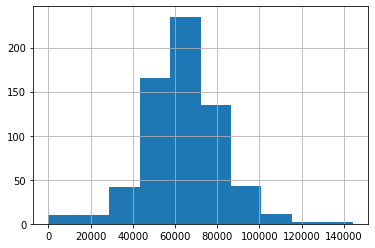

In [9]:
#Visualise the length of words
pd.Series(df['length'] ).hist()

In [10]:
#Remove scripts with less than 200 words
df = df [df['length'] > 200 ]

<AxesSubplot:>

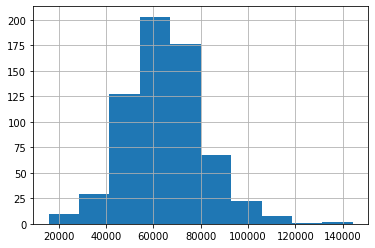

In [11]:
#Visualise after discarding less than 200 words
pd.Series(df['length'] ).hist()


Since the scripts were not lemmatized initially, so that character names could be easily removed. The next operation will be to lemmatize the scripts. so that all words can be uniformly reduced to their root words.

In [12]:
def lemmatize_script (df_col):
    ''' The function takes in the a pandas series and 
        returns a lemmatized output of the series '''
    
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    script =  [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(df_col)]
    return ' '.join(script)



df['movie_script'] = df.movie_script.apply(lemmatize_script)


Since the movie script has now been lemmatized, the distribution of words across the scripts can be visualised using word cloud. This will show the frequently occuring words across all scripts.

In [13]:
def plot_wordcloud (df_col):
    ''' The function takes in a pandas series of string input
        and returns a visual of top occuring words '''
    
    words = ','.join(list(df_col.values))
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue').generate(words)
    return wordcloud.to_image()


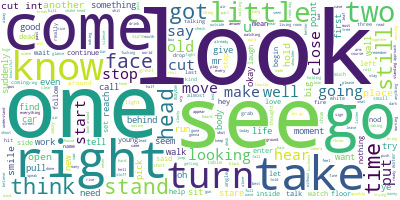

In [14]:
plot_wordcloud(df['movie_script'])

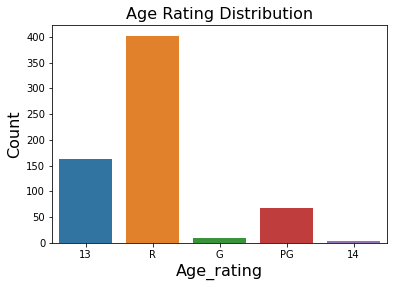

In [15]:
#To visualize the class distribution of the target label
sns.countplot (df['age_rating'])
plt.title('Age Rating Distribution', {'size':16})
plt.xlabel( 'Age_rating', fontdict= {'size':16})
plt.ylabel ('Count', fontdict= {'size':16})
plt.show()

The data set clearly needs to be balanced. 


before balancing, '13' and '14' will be grouped as 14, giving four classes to be predicted.

A section of the data will also be held out for testing. This will be used to evaluate how well the models will perform on new sets of data that has not been seen at all by the model.

In [16]:
#Class all '13' rated movies as '14'
df['age_rating'] = np.where ( (df['age_rating'] == '13'), '14', df['age_rating'] )

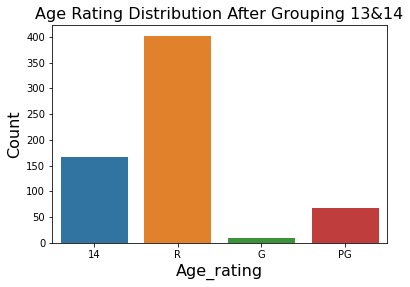

In [17]:
sns.countplot (df['age_rating'])
plt.title('Age Rating Distribution After Grouping 13&14', {'size':16})
plt.xlabel( 'Age_rating', fontdict= {'size':16})
plt.ylabel ('Count', fontdict= {'size':16})
plt.show()

The last 55 entries of the data set will be used for the testing data

In [18]:
test_df = df.tail(55)

In [19]:
#The remaining part of the data set will be used for training and validation
use_df = df [:590]

In [20]:
#Check the target label in the test data to ensure all class labels are represented
test_df['age_rating'].unique()

array(['G', 'R', '14', 'PG'], dtype=object)

The dataset will now be balanced to be used for training the models
Since only the 'movie_script' and the 'age_rating' feature is needed, they will only be used

In [21]:
use_df = use_df[['movie_script', 'age_rating']]
test_df = test_df[['movie_script', 'age_rating' ]]

In [22]:
use_df.head()

,movie_script,age_rating
0,ten thing hate mccullah lutz ten thing hate mc...,14
1,holding cipriano fade neighborhood street morn...,R
2,twelve monkey twelve monkey original screenpla...,R
3,cut black title fin exterior la day fin chevy ...,14
4,hour beaufoy scene various massive could sport...,R


The dataset will now be balanced using the NLP AUG library

In [23]:
#Initialize the augmeter
augmeter = aug.ContextualWordEmbsAug (model_path = 'bert-base-uncased', action= 'insert')

In [24]:
def augmentData (df, aug, rating, samples):
    
    ''' The function takes the dataframe, the augmeter object, the class to be upsampled in the target label
        and the count of the highest occuring class '''
    
    #Empty list to store the augmented text data
    augmented = []
    #Creates a new dataframe where the 'age_rating' is the class to be upsampled
    n_df = df[df['age_rating'] == rating ].reset_index (drop = True) 
    
    #defines the number of times the augmentation should be carried out on each of the scripts.
    #This will help to have a unifrom distribution of among the augmented scripts
    repetition = int (most/len(n_df))
    
    for i in   range (len (n_df)):
        
        for _ in range (repetition):
            
            augmented_text = aug.augment (n_df['movie_script'].iloc[i])
            
            augmented.append(augmented_text)
            
    data = {'age_rating': rating,
            
            'movie_script': augmented }

    aug_df = pd.DataFrame(data)
    
    df = df.append(aug_df).reset_index(drop = True)
    
    
    return df 

Since only the 'movie_script' and 'age_rating' will be needed from this point on, the other columns will be left out for now

In [25]:
#compute the class with the most values
most = use_df['age_rating'].value_counts().max()

In [26]:
#balancing the data set
df_bal = augmentData (use_df, augmeter, '14', samples = most)
df_bal = augmentData (df_bal, augmeter, 'PG', samples = most)
df_bal = augmentData (df_bal, augmeter, 'G', samples = most)

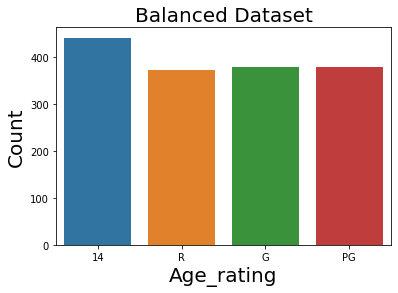

In [27]:
#After augmenting the data
sns.countplot (df_bal['age_rating'])
plt.title('Balanced Dataset', {'size':20})
plt.xlabel( 'Age_rating', fontdict= {'size':20})
plt.ylabel ('Count', fontdict= {'size':20})
plt.show()

The data set can now be trained with naive bayes, which has been chosen as the baseline model.

Before training:  

the values of 'age_rating' will be assigned integer values using the LabelEncoder 

the data will be split into training and test sets

the training and test sets will be pre-processed

In [28]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(df_bal['age_rating'])

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df_bal['movie_script'], y, test_size=0.20, random_state=100, stratify= y)

In [30]:
#create the vectorizer object and fit on the training data
vectorizer = TfidfVectorizer(analyzer= 'word')
#fit the vectorizer on the training data
vectorizer.fit(x_train)

TfidfVectorizer()

In [31]:
#The vectorizer can now be used to transform the training and the test data
xtrain = vectorizer.transform(x_train).toarray()
xtest = vectorizer.transform(x_test).toarray()

In [32]:
#Create an instance of the baseline model and fit on the training data
base_line = MultinomialNB()

In [33]:
%%time
base_line.fit (xtrain, y_train)

Wall time: 296 ms


MultinomialNB()

In [34]:
#predict on the test data
base_pred = base_line.predict(xtest)

In [35]:
base_accuracy = accuracy_score(base_pred, y_test)
base_accuracy = round (base_accuracy *100)

In [36]:
print('Base Line Accuracy:', base_accuracy)

Base Line Accuracy: 66


train and test data with  XGBoost classifier

In [37]:
#create the classifier object, using its default parameters    
xg = XGBClassifier()

In [38]:
%%time
#train the data
xg.fit (xtrain, y_train)

Wall time: 4min 14s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [39]:
xg_pred = xg.predict(xtest)

In [40]:
xg_accuracy = accuracy_score (xg_pred, y_test)
xg_accuracy = round (xg_accuracy * 100)

In [41]:
print('XGBoost Accuracy:', xg_accuracy)

XGBoost Accuracy: 95


The data was trained by the XGBoost classifier for 5mins 56secs and achieved 95% accuracy on the test data

The model will now be tested on new sets of data to see how well it performs

In [42]:
#The data to be used
test_df

,movie_script,age_rating
599,toy story break frame website abstraction http...,G
600,gaghan gaghan based miniseries traffik columbu...,R
601,training day ayer training day ayer draft augu...,R
602,trainspotting screenplay based novel irvine we...,R
603,maddock tremor beneath perfection maddock dese...,14
604,digitized special duarte physical copy based s...,PG
605,tropic thunder stiller theroux movie black mov...,R
606,true grit adaptation coen based novel portis w...,14
607,u title sequence mountain near geneva switzerl...,R
608,true romance body background color ffffff font...,R


The movie script and age rating column will be pre-processed before feeding into the model

In [43]:
#Vectorize and encode the data
test_data = vectorizer.transform(test_df['movie_script']).toarray()
test_target = label_encode.fit_transform(test_df['age_rating'])

In [44]:
#Make predictions on the test data
prediction = xg.predict(test_data)

In [45]:
prediction

array([1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 2, 3, 0,
       2, 3, 0, 3, 3, 0, 3, 0, 3, 3, 3], dtype=int64)

In [46]:
test_target

array([1, 3, 3, 3, 0, 2, 3, 0, 3, 3, 0, 3, 2, 3, 3, 0, 0, 3, 2, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 2, 3, 0, 3, 0,
       2, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3])

In [47]:
xg_test_accuracy = accuracy_score (prediction, test_target)

In [48]:
print('Accuracy on New Test Data  : {:.2f}'.format(xg_test_accuracy))

Accuracy on New Test Data  : 0.73


The XGBoost classifier achieved 75% accuracy in classifying new movie script data into age rating

In [49]:
print ('XGboost accuracy score:',  round (xg_test_accuracy, 2))

print ('\n Classificaton Report: \n',classification_report(prediction, test_target))

XGboost accuracy score: 0.73

 Classificaton Report: 
               precision    recall  f1-score   support

           0       0.53      0.62      0.57        16
           1       1.00      1.00      1.00         1
           2       0.20      0.50      0.29         2
           3       0.93      0.78      0.85        36

    accuracy                           0.73        55
   macro avg       0.66      0.73      0.68        55
weighted avg       0.79      0.73      0.75        55



In [50]:
xg_test_accuracy = round (xg_test_accuracy * 100)
print (xg_test_accuracy)

73


# Using an embedding layer with CNN

The data will be pre-processed differently for this purpose

The steps involved here are to tokenize and encode the data. The length of the input vector will also be defined. data with shorter lenght will be padded


In [51]:
#Function to tokenize and encode training and test data
#This function will also tokenize the test_df data as well, since it will be used to test the model later on
def token_encode (train_data, test_data, new_data):
    '''Function to encode the train and test data
        It takes the train and test data and returns thier corresponding 
        padded vectors as well as the input dimensions to the embedding layer'''
    tokenizer = Tokenizer(oov_token= '<OOV>')
    #fit tokenizer on train data and encode
    tokenizer.fit_on_texts (train_data)
    length = max([len(s.split()) for s in train_data])
    encoded_train = tokenizer.texts_to_sequences(train_data)
    padded_train = pad_sequences (encoded_train, length, padding= 'post')
    #encode test data
    encoded_test = tokenizer.texts_to_sequences(test_data)
    padded_test = pad_sequences (encoded_test, length, padding= 'post')
    #encode new data
    encoded_new = tokenizer.texts_to_sequences(new_data)
    padded_new = pad_sequences (encoded_new, length, padding= 'post')
    
    size = len (tokenizer.word_index ) + 1
    
    return padded_train, padded_test, padded_new, size, length
    

SInce neural networks will be used from this pouint.The target label will be encoded using the Label binarizer to give binary arrays.

In [52]:
#Hot encode the target label
binary_encode = LabelBinarizer()
y = binary_encode.fit_transform(df_bal['age_rating'])

In [53]:
#Perform the train test split, using thesame test size and random state
x_train, x_test, y_train, y_test = train_test_split(df_bal['movie_script'], y, test_size=0.2, random_state=100, stratify= y)

In [54]:
#Prepare the data for training
padded_train, padded_test, padded_new, size, length = token_encode (x_train, x_test, test_df['movie_script'])

The frist embedding model will be trianed over 20 epochs with an input batch size of 128 with an output dimension of 150, 32, filters, kernel size 2, using the default learning rate and one hidden layer

In [55]:
model1 = Sequential()
model1.add(Embedding(size, 150, input_length=length, trainable = True))
model1.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(300, activation='relu'))

model1.add(Dense(4, activation='softmax'))

In [56]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21115, 150)        11077350  
                                                                 
 conv1d (Conv1D)             (None, 21114, 32)         9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10557, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 337824)            0         
                                                                 
 dense (Dense)               (None, 300)               101347500 
                                                                 
 dense_1 (Dense)             (None, 4)                 1204      
                                                        

In [58]:
%%time
history1 = model1.fit(padded_train, y_train, batch_size=64, shuffle=True, epochs=20, verbose=True, validation_data= (padded_test, y_test))


Epoch 1/20
20/20 [==============================] - 70s 3s/step - loss: 4.1709 - accuracy: 0.4562 - val_loss: 0.8935 - val_accuracy: 0.6879
Epoch 2/20
20/20 [==============================] - 71s 4s/step - loss: 0.5575 - accuracy: 0.8400 - val_loss: 0.3724 - val_accuracy: 0.8822
Epoch 3/20
20/20 [==============================] - 72s 4s/step - loss: 0.1272 - accuracy: 0.9944 - val_loss: 0.1846 - val_accuracy: 0.9427
Epoch 4/20
20/20 [==============================] - 64s 3s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1590 - val_accuracy: 0.9427
Epoch 5/20
20/20 [==============================] - 64s 3s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1625 - val_accuracy: 0.9459
Epoch 6/20
20/20 [==============================] - 64s 3s/step - loss: 9.1842e-04 - accuracy: 1.0000 - val_loss: 0.1578 - val_accuracy: 0.9427
Epoch 7/20
20/20 [==============================] - 65s 3s/step - loss: 6.7004e-04 - accuracy: 1.0000 - val_loss: 0.1569 - val_accuracy: 0.9427
Epoch 8/20
2

In [59]:
#Function to plot the metric outputs from the neural network
def plot_result(history):
    '''Function to plot the training and loss accuracies of the neural network.
    It takes in the vlaues of the training results and outputs the line plot'''
    
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].set_title('Loss Plot', fontsize = 14)
    axes[1].set_title('Accuracy Plot', fontsize = 14)
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].legend(fontsize = 14)
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].legend(fontsize = 14)
    
    
    return plt.show()

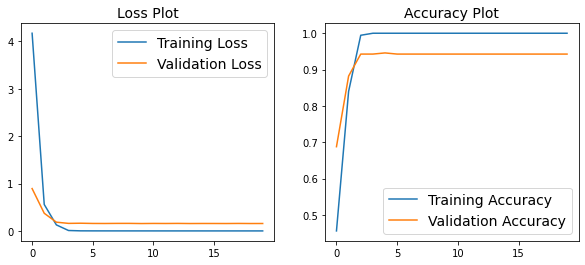

In [60]:
plot_result(history1 )

At around the 4th epoch, the loss became constant. The training accuracy also reached 100%. This suggests an overfitting into the training data

Drop out layer will be introduced, the batch size will be increased and early stopping as well

In [61]:
model2 = Sequential()
model2.add(Embedding(size, 150, input_length=length, trainable = True))

model2.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(300, activation='relu'))
model2.add(Dense(4, activation='softmax'))
es = EarlyStopping(monitor = 'val_loss', patience=4)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
%%time
history2 = model2.fit(padded_train, y_train, batch_size= 128, shuffle=True, epochs=20, verbose=True,
                      validation_data= (padded_test, y_test), callbacks = [es])


Epoch 1/20
10/10 [==============================] - 81s 7s/step - loss: 6.9277 - accuracy: 0.3575 - val_loss: 1.0043 - val_accuracy: 0.5064
Epoch 2/20
10/10 [==============================] - 64s 6s/step - loss: 0.8576 - accuracy: 0.6019 - val_loss: 0.7581 - val_accuracy: 0.7420
Epoch 3/20
10/10 [==============================] - 64s 6s/step - loss: 0.5912 - accuracy: 0.8758 - val_loss: 0.5668 - val_accuracy: 0.8790
Epoch 4/20
10/10 [==============================] - 65s 7s/step - loss: 0.2607 - accuracy: 0.9984 - val_loss: 0.3133 - val_accuracy: 0.9331
Epoch 5/20
10/10 [==============================] - 64s 6s/step - loss: 0.0510 - accuracy: 0.9992 - val_loss: 0.2012 - val_accuracy: 0.9427
Epoch 6/20
10/10 [==============================] - 65s 6s/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.1670 - val_accuracy: 0.9490
Epoch 7/20
10/10 [==============================] - 65s 7s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.1576 - val_accuracy: 0.9427
Epoch 8/20
10/10 [==

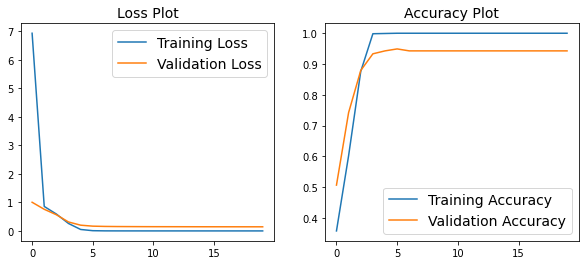

In [63]:
plot_result(history2)

The result still looks similar to that of model1

Using output dimension of 200, and increasing the number of hidden layers as well as changing the learning rate

In [64]:
model3 = Sequential()
model3.add(Embedding(size, 200, input_length=length, trainable = True))
#model2.add(Dropout(0.2))
model3.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))

model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation='relu'))
#model2.add(Dropout(0.2))
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#opt = optimizers.Adam(learning_rate= 0.0001)
#model3.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])



In [65]:
%%time
history3 = model3.fit(padded_train, y_train, batch_size=128, shuffle=True, epochs=20, verbose=True,
                      validation_data= (padded_test, y_test),callbacks= [es] )



Epoch 1/20
10/10 [==============================] - 75s 7s/step - loss: 2.9290 - accuracy: 0.2818 - val_loss: 1.3718 - val_accuracy: 0.2484
Epoch 2/20
10/10 [==============================] - 69s 7s/step - loss: 1.3226 - accuracy: 0.3662 - val_loss: 1.2893 - val_accuracy: 0.3981
Epoch 3/20
10/10 [==============================] - 69s 7s/step - loss: 1.1926 - accuracy: 0.4570 - val_loss: 1.1278 - val_accuracy: 0.5318
Epoch 4/20
10/10 [==============================] - 68s 7s/step - loss: 0.9881 - accuracy: 0.5318 - val_loss: 0.8598 - val_accuracy: 0.5541
Epoch 5/20
10/10 [==============================] - 68s 7s/step - loss: 0.8026 - accuracy: 0.5995 - val_loss: 0.7338 - val_accuracy: 0.6529
Epoch 6/20
10/10 [==============================] - 70s 7s/step - loss: 0.6647 - accuracy: 0.6911 - val_loss: 0.5855 - val_accuracy: 0.7930
Epoch 7/20
10/10 [==============================] - 69s 7s/step - loss: 0.5186 - accuracy: 0.8010 - val_loss: 0.4259 - val_accuracy: 0.8662
Epoch 8/20
10/10 [==

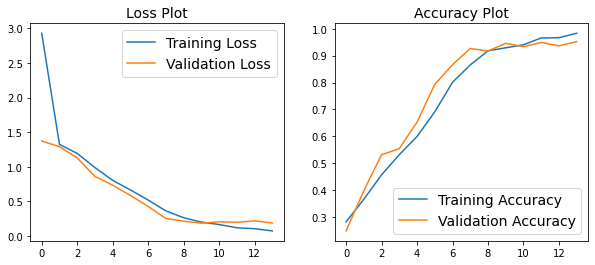

In [66]:
plot_result(history3)

In [67]:
#The cnn accuracy
cnn_accuracy = round (model3.evaluate(padded_test, y_test, verbose=0)[1]  * 100 )
print (cnn_accuracy)

95


The model will be tested on a new data set to see how well it classifies new data

In [68]:
#encode the target class of the new data
y_new = binary_encode.fit_transform(test_df['age_rating'])

In [69]:
cnn_test_accuracy = round ( ( model3.evaluate(padded_new, y_new, verbose=0)[1] ) * 100 ) 
cnn_test_accuracy

58

# BERT

The code for BERT implementation was from (https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4). And modified for the purpose of this research

In [70]:
#file path to pre-process and transform the scripts
process_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encode_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [71]:
preprocess = hub.KerasLayer(process_url)

encode = hub.KerasLayer(encode_url )

In [72]:
text_input = keras.layers.Input(shape=(), dtype= tf.string )

#The text_input will be passed into the bert preprocessing model and encoder

processed_text = preprocess(text_input)

encoded_text = encode (processed_text)


Functional neural network will be used here

In [73]:
xbert = keras.layers.Dropout(0.2)(encoded_text['pooled_output']) 
xbert = keras.layers.Dense(400, activation = 'relu') (xbert)
xbert = keras.layers.Dense(4, activation = 'softmax') (xbert)

In [74]:
model_bert = keras.Model(inputs = [text_input], outputs = [xbert])

In [75]:
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
%%time
history_bert = model_bert.fit (x_train, y_train, verbose= True, epochs= 20, validation_data= (x_test, y_test))

Epoch 1/20
40/40 [==============================] - 445s 11s/step - loss: 1.4255 - accuracy: 0.3264 - val_loss: 1.2567 - val_accuracy: 0.3949
Epoch 2/20
40/40 [==============================] - 464s 12s/step - loss: 1.2343 - accuracy: 0.4037 - val_loss: 1.1519 - val_accuracy: 0.4777
Epoch 3/20
40/40 [==============================] - 472s 12s/step - loss: 1.1202 - accuracy: 0.4697 - val_loss: 1.1210 - val_accuracy: 0.5032
Epoch 4/20
40/40 [==============================] - 467s 12s/step - loss: 1.1003 - accuracy: 0.4737 - val_loss: 0.9982 - val_accuracy: 0.5000
Epoch 5/20
40/40 [==============================] - 464s 12s/step - loss: 1.0086 - accuracy: 0.5127 - val_loss: 0.9515 - val_accuracy: 0.5255
Epoch 6/20
40/40 [==============================] - 464s 12s/step - loss: 0.9644 - accuracy: 0.5350 - val_loss: 0.9125 - val_accuracy: 0.5318
Epoch 7/20
40/40 [==============================] - 464s 12s/step - loss: 0.9409 - accuracy: 0.5446 - val_loss: 0.9335 - val_accuracy: 0.5255
Epoch 

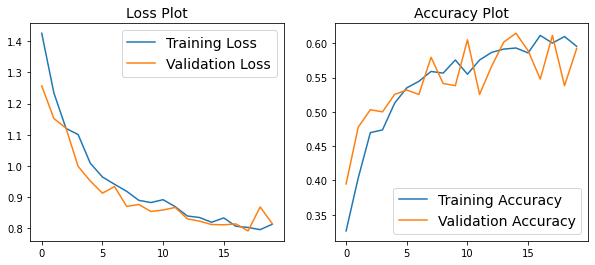

In [77]:
plot_result(history_bert)

In [78]:
bert_accuracy = round (model_bert.evaluate(x_test, y_test, verbose=0)[1]  * 100 )
print (bert_accuracy)

59


# Bert with extra layer

In [79]:
xbert2 = keras.layers.Dropout(0.2)(encoded_text['pooled_output']) 
xbert2 = keras.layers.Dense(400, activation = 'relu') (xbert2)
xbert2 = keras.layers.Dropout(0.5)(xbert2)
xbert2 = keras.layers.Dense(200, activation = 'relu') (xbert2)

xbert2 = keras.layers.Dense(4, activation = 'softmax') (xbert2)


In [80]:
model_bert2 = keras.Model(inputs = [text_input], outputs = [xbert2])

In [81]:

model_bert2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
%%time
history_bert2 = model_bert2.fit (x_train, y_train, verbose= True, epochs= 40, validation_data= (x_test, y_test))

Epoch 1/40
40/40 [==============================] - 345s 9s/step - loss: 1.4894 - accuracy: 0.2803 - val_loss: 1.3303 - val_accuracy: 0.2930
Epoch 2/40
40/40 [==============================] - 349s 9s/step - loss: 1.3627 - accuracy: 0.3153 - val_loss: 1.2751 - val_accuracy: 0.3949
Epoch 3/40
40/40 [==============================] - 358s 9s/step - loss: 1.3026 - accuracy: 0.3495 - val_loss: 1.2114 - val_accuracy: 0.4076
Epoch 4/40
40/40 [==============================] - 359s 9s/step - loss: 1.2485 - accuracy: 0.3806 - val_loss: 1.1721 - val_accuracy: 0.3503
Epoch 5/40
40/40 [==============================] - 359s 9s/step - loss: 1.1858 - accuracy: 0.4204 - val_loss: 1.0942 - val_accuracy: 0.4777
Epoch 6/40
40/40 [==============================] - 359s 9s/step - loss: 1.1278 - accuracy: 0.4220 - val_loss: 1.0903 - val_accuracy: 0.4459
Epoch 7/40
40/40 [==============================] - 361s 9s/step - loss: 1.0933 - accuracy: 0.4427 - val_loss: 0.9919 - val_accuracy: 0.5127
Epoch 8/40
40

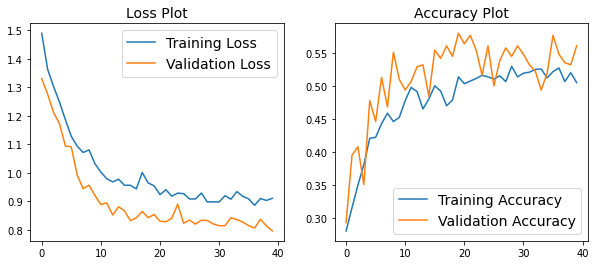

In [83]:
plot_result(history_bert2)

In [84]:
bert_accuracy2 = round (model_bert2.evaluate(x_test, y_test, verbose=0)[1]  * 100 )
print(bert_accuracy2)

56


# Next task is to build the LDA model


The code used for the topic modeling was from https://www.dataknowsall.com/topicmodels.html. It was modified to fit in to this experiment

The orignal data frame will be used for the topic modeling

In [85]:
#re-import the data frame
df = pd.read_csv('movie_data.csv')

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         655 non-null    object
 1   movie_script  655 non-null    object
 2   movie_genre   655 non-null    object
 3   age_rating    655 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In order to create the topic model, the first genre entry of all the movies were used. This was assumed to be the genre that dominates in the movie

In [87]:
#Function to extract the first genre entry
def create_genre_list (df):
    ''' The function takes a series, splits the string in the series,
        appends the first element in the list to a new list
        and create a frequency count of the genres.
        The first genre list and frequency count will be returned
                                                                '''
    first_genre = []
    lst = [genre.split() for genre in df]
    for word in lst:
        first_genre.append(word[0])
    first_genre = ' '.join(first_genre) 
    first_genre = first_genre.replace(',', '')
    first_genre = first_genre.split()
    first_genre = [word.lower() for word in first_genre]
    
    
    return first_genre, nltk.FreqDist(first_genre)

In [88]:
genre_list, genre_frequency = create_genre_list(df['movie_genre'])

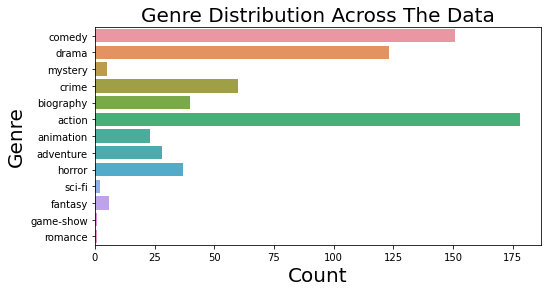

In [89]:
#Visualize how the genres appear in the dataset
plt.figure(figsize=(8,4)) 
sns.barplot(y= list (genre_frequency.keys()), x = list( genre_frequency.values()) )
plt.title('Genre Distribution Across The Data', fontdict={'size':20})
plt.xlabel( 'Count', fontdict= {'size':20})
plt.ylabel ('Genre', fontdict= {'size':20})
plt.show()


A cluster was also created for the movies, where closely related movies are put in the same clusters.

From the first genre generated, five clusters were created. 

A = Drama, Comedy,  Biography, Game-Show
	
B = Romance, Adventure
	
C = Sci-Fi, Fantasy, Animation, Action
	
D = Crime, Mystery
	
E = Horror

In [90]:
#Creating the cluster list
cluster_list = []
for genre in genre_list:
    if (genre == 'drama') | ( genre == 'comedy')  | ( genre == 'biography') | ( genre == 'game-show') :
        cluster_list.append('a')
    if ( genre == 'romance') | ( genre == 'adventure'):
        cluster_list.append('b')
    if ( genre == 'sci-fi') | ( genre == 'fantasy')  | ( genre == 'animation') | ( genre == 'action'):
        cluster_list.append('c')
    if ( genre == 'crime') | ( genre == 'mystery'):
        cluster_list.append('d')
    if ( genre == 'horror'):
        cluster_list.append('e')

In [91]:
#appending the cluster list and first genre to the data frame
df['first_genre'] = genre_list
df['genre_cluster'] = cluster_list

The scripts will now be prepared for the LDA model.

First step is to create a list of all the words in the scripts in the data set

In [92]:
#create a list of words in the script.
tokens = []

scripts = [word.split() for word in df['movie_script']]

for items in range(len(scripts)): 
    for words in range (len(scripts[items])): 
        tokens.append(scripts[items][words])     
        
print (len(tokens))

6366843


Of the 6366843 words, only words with word length greater than three will be considered. This will help reduce the words and filter out the common pronouns and prepositions

In [93]:
#keep only words where the legth of characters is more than 3
tokens = [word for word in tokens if len(word) > 3]
print (len(tokens))

5612759


The number of words has been reduced by almost 1,000,000

In [94]:
#Create a frequency to represent the count of words

frequency = defaultdict(int)

for token in tokens:
    frequency[token] += 1

In [95]:
#Remove words that appear less than two tines from the scripts

scripts = [[word for word in text if frequency[word] > 2]  for text in scripts]

In [96]:
#make a dictionary of words from the filtered scripts

dictionary = corpora.Dictionary(scripts)

In order to reduce the words in the scripts to words that correctly identifies what genre the scripts belong to, a boundary will be defined for how the words appear in the document, so as to find a balance between words that are general, and words that are common across genres

In [97]:
#define the set of boundaries to use
minimum = [20, 30, 40, 50, 60, 70, 80]
maximum = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for min_val in minimum:
    
    for max_val in maximum:
        
        dictionary = corpora.Dictionary(scripts)
        
        print ('using no_below =',min_val , 'and no_above =',max_val)
        dictionary.filter_extremes(no_below=min_val , no_above= max_val )
        corpus = [dictionary.doc2bow(text) for text in scripts]
        ldamodel = LdaModel (id2word= dictionary, corpus= corpus,  num_topics = 5, alpha='auto',
                         eta='auto', iterations=100, passes=20, eval_every=10, random_state=100, chunksize=5, )
#Print the results from each iteration                
        
        pprint (ldamodel.print_topics())

using no_below = 20 and no_above = 0.2
[(0,
  '0.021*"rooster" + 0.016*"crow" + 0.015*"tent" + 0.011*"sword" + '
  '0.009*"leaf" + 0.008*"jungle" + 0.006*"trench" + 0.006*"warriors" + '
  '0.005*"creatures" + 0.005*"spear"'),
 (1,
  '0.033*"willow" + 0.011*"rabbit" + 0.008*"august" + 0.005*"barn" + '
  '0.005*"goose" + 0.004*"gale" + 0.004*"oldsmobile" + 0.003*"rover" + '
  '0.003*"sail" + 0.003*"stranded"'),
 (2,
  '0.014*"august" + 0.012*"madison" + 0.009*"manhattan" + 0.008*"alabama" + '
  '0.007*"prince" + 0.006*"german" + 0.006*"writers" + 0.004*"circus" + '
  '0.004*"london" + 0.004*"hitler"'),
 (3,
  '0.014*"revisions" + 0.004*"thug" + 0.004*"chopper" + 0.004*"hatch" + '
  '0.004*"cockpit" + 0.003*"missile" + 0.003*"trailer" + 0.003*"rocket" + '
  '0.003*"port" + 0.003*"wham"'),
 (4,
  '0.009*"smiley" + 0.005*"babe" + 0.004*"trailer" + 0.004*"closeup" + '
  '0.003*"korean" + 0.003*"golf" + 0.002*"potato" + 0.002*"mustang" + '
  '0.002*"roach" + 0.002*"abraham"')]
using no_below 

[(0,
  '0.028*"ship" + 0.025*"deck" + 0.020*"boat" + 0.015*"crew" + 0.014*"plane" + '
  '0.011*"alabama" + 0.009*"bridge" + 0.008*"military" + 0.007*"helicopter" + '
  '0.006*"bomb"'),
 (1,
  '0.004*"horses" + 0.004*"stage" + 0.004*"tent" + 0.003*"prince" + '
  '0.003*"perhaps" + 0.003*"writers" + 0.003*"german" + 0.003*"snow" + '
  '0.002*"cannot" + 0.002*"shall"'),
 (2,
  '0.005*"train" + 0.003*"corridor" + 0.003*"desert" + 0.003*"steel" + '
  '0.003*"bridge" + 0.003*"tunnel" + 0.002*"bullets" + 0.002*"rifle" + '
  '0.002*"guns" + 0.002*"mask"'),
 (3,
  '0.008*"apartment" + 0.005*"hotel" + 0.003*"madison" + 0.003*"bank" + '
  '0.003*"smiley" + 0.003*"photo" + 0.003*"club" + 0.003*"fuckin" + '
  '0.003*"manhattan" + 0.003*"dollars"'),
 (4,
  '0.014*"willow" + 0.006*"august" + 0.006*"buzz" + 0.006*"continuous" + '
  '0.005*"revisions" + 0.004*"highway" + 0.004*"rabbit" + 0.003*"yellow" + '
  '0.003*"trailer" + 0.003*"porch"')]
using no_below = 20 and no_above = 0.7


[(0,
  '0.009*"ship" + 0.009*"deck" + 0.007*"boat" + 0.007*"bridge" + 0.005*"crew" '
  '+ 0.004*"tunnel" + 0.004*"surface" + 0.004*"steel" + 0.003*"desert" + '
  '0.003*"base"'),
 (1,
  '0.005*"continuous" + 0.005*"apartment" + 0.004*"fucking" + 0.004*"smiley" + '
  '0.004*"ball" + 0.004*"evening" + 0.003*"wanna" + 0.003*"honey" + '
  '0.003*"movie" + 0.003*"beer"'),
 (2,
  '0.009*"willow" + 0.004*"towards" + 0.004*"buzz" + 0.004*"wild" + '
  '0.004*"snow" + 0.003*"tree" + 0.003*"train" + 0.003*"rain" + 0.003*"bird" + '
  '0.003*"trees"'),
 (3,
  '0.013*"angle" + 0.008*"august" + 0.008*"truck" + 0.006*"bank" + '
  '0.006*"apartment" + 0.006*"madison" + 0.005*"revisions" + 0.004*"highway" + '
  '0.004*"trailer" + 0.003*"hotel"'),
 (4,
  '0.005*"alabama" + 0.004*"prince" + 0.004*"country" + 0.004*"german" + '
  '0.003*"writers" + 0.003*"american" + 0.003*"horses" + 0.003*"army" + '
  '0.003*"perhaps" + 0.003*"letter"')]
using no_below = 20 and no_above = 0.8


[(0,
  '0.008*"willow" + 0.004*"wind" + 0.004*"road" + 0.003*"snow" + '
  '0.003*"towards" + 0.003*"wild" + 0.003*"tree" + 0.003*"trees" + '
  '0.003*"glances" + 0.003*"beside"'),
 (1,
  '0.005*"school" + 0.003*"party" + 0.003*"continuous" + 0.003*"game" + '
  '0.003*"evening" + 0.003*"ball" + 0.003*"apartment" + 0.002*"hallway" + '
  '0.002*"coffee" + 0.002*"bottle"'),
 (2,
  '0.009*"august" + 0.005*"city" + 0.005*"alabama" + 0.004*"american" + '
  '0.004*"prince" + 0.004*"train" + 0.004*"country" + 0.004*"german" + '
  '0.003*"fight" + 0.003*"army"'),
 (3,
  '0.010*"ship" + 0.010*"deck" + 0.007*"boat" + 0.007*"bridge" + 0.005*"crew" '
  '+ 0.005*"space" + 0.005*"metal" + 0.005*"speed" + 0.004*"steel" + '
  '0.004*"power"'),
 (4,
  '0.009*"angle" + 0.006*"truck" + 0.005*"apartment" + 0.005*"cars" + '
  '0.005*"gotta" + 0.004*"bank" + 0.004*"madison" + 0.004*"smiley" + '
  '0.004*"revisions" + 0.004*"road"')]
using no_below = 30 and no_above = 0.2


[(0,
  '0.049*"august" + 0.020*"rooster" + 0.015*"prince" + 0.014*"german" + '
  '0.014*"tent" + 0.013*"barn" + 0.009*"hitler" + 0.008*"circus" + '
  '0.007*"colt" + 0.007*"texas"'),
 (1,
  '0.007*"babe" + 0.007*"writers" + 0.005*"london" + 0.004*"gallery" + '
  '0.004*"goose" + 0.004*"superior" + 0.003*"laden" + 0.003*"corn" + '
  '0.003*"donuts" + 0.003*"stadium"'),
 (2,
  '0.008*"madison" + 0.008*"revisions" + 0.006*"manhattan" + 0.006*"trailer" + '
  '0.004*"closeup" + 0.003*"warehouse" + 0.003*"korean" + 0.002*"ford" + '
  '0.002*"golf" + 0.002*"subway"'),
 (3,
  '0.012*"rabbit" + 0.007*"crow" + 0.005*"sword" + 0.003*"port" + '
  '0.003*"branches" + 0.003*"hatch" + 0.003*"cockpit" + 0.003*"sail" + '
  '0.003*"canyon" + 0.003*"cave"'),
 (4,
  '0.014*"jungle" + 0.014*"thug" + 0.014*"chopper" + 0.013*"leaf" + '
  '0.012*"missile" + 0.011*"compound" + 0.011*"transport" + 0.010*"wham" + '
  '0.010*"console" + 0.009*"trench"')]
using no_below = 30 and no_above = 0.3
[(0,
  '0.008*"augus

[(0,
  '0.006*"hotel" + 0.006*"continuous" + 0.004*"madison" + 0.004*"fuckin" + '
  '0.003*"manhattan" + 0.003*"alright" + 0.003*"television" + 0.003*"lobby" + '
  '0.002*"elevator" + 0.002*"trunk"'),
 (1,
  '0.007*"buzz" + 0.005*"revisions" + 0.004*"snow" + 0.003*"flashlight" + '
  '0.003*"steel" + 0.003*"cage" + 0.003*"woods" + 0.003*"mask" + 0.003*"beam" '
  '+ 0.003*"bullets"'),
 (2,
  '0.016*"august" + 0.012*"deck" + 0.012*"ship" + 0.011*"boat" + '
  '0.009*"bridge" + 0.008*"plane" + 0.008*"crew" + 0.005*"camp" + '
  '0.005*"prince" + 0.005*"beach"'),
 (3,
  '0.005*"rabbit" + 0.004*"rooster" + 0.004*"restaurant" + 0.003*"babe" + '
  '0.003*"writers" + 0.003*"wedding" + 0.002*"continuing" + 0.002*"letter" + '
  '0.002*"shall" + 0.002*"farm"'),
 (4,
  '0.012*"bird" + 0.011*"forest" + 0.011*"crow" + 0.010*"desert" + '
  '0.009*"horses" + 0.009*"tent" + 0.008*"sword" + 0.008*"village" + '
  '0.007*"mountain" + 0.007*"battle"')]
using no_below = 30 and no_above = 0.6


[(0,
  '0.009*"apartment" + 0.006*"continuous" + 0.005*"hotel" + 0.004*"august" + '
  '0.004*"bank" + 0.004*"beer" + 0.004*"shooting" + 0.004*"club" + '
  '0.003*"honey" + 0.003*"fuckin"'),
 (1,
  '0.026*"ship" + 0.025*"deck" + 0.018*"boat" + 0.014*"crew" + 0.014*"plane" + '
  '0.012*"bridge" + 0.007*"military" + 0.007*"helicopter" + 0.006*"bomb" + '
  '0.006*"base"'),
 (2,
  '0.010*"snow" + 0.007*"trees" + 0.007*"bird" + 0.006*"tent" + '
  '0.006*"rooster" + 0.005*"cage" + 0.005*"forest" + 0.005*"woods" + '
  '0.005*"horses" + 0.005*"crow"'),
 (3,
  '0.004*"august" + 0.003*"prince" + 0.003*"stage" + 0.003*"german" + '
  '0.003*"perhaps" + 0.002*"train" + 0.002*"writers" + 0.002*"letter" + '
  '0.002*"circus" + 0.002*"cannot"'),
 (4,
  '0.005*"buzz" + 0.004*"train" + 0.004*"madison" + 0.004*"revisions" + '
  '0.003*"corridor" + 0.003*"continuing" + 0.002*"guns" + 0.002*"cell" + '
  '0.002*"yellow" + 0.002*"engine"')]
using no_below = 30 and no_above = 0.7


[(0,
  '0.025*"ship" + 0.022*"boat" + 0.021*"deck" + 0.012*"crew" + 0.011*"snow" + '
  '0.010*"camp" + 0.009*"horses" + 0.009*"bird" + 0.008*"bridge" + '
  '0.008*"field"'),
 (1,
  '0.005*"towards" + 0.004*"buzz" + 0.003*"roof" + 0.003*"knife" + '
  '0.003*"cage" + 0.003*"beneath" + 0.003*"train" + 0.002*"trees" + '
  '0.002*"leaps" + 0.002*"tree"'),
 (2,
  '0.015*"angle" + 0.008*"august" + 0.007*"madison" + 0.007*"plane" + '
  '0.005*"american" + 0.004*"train" + 0.004*"monitor" + 0.004*"bank" + '
  '0.004*"interior" + 0.004*"elevator"'),
 (3,
  '0.004*"evening" + 0.003*"august" + 0.002*"stage" + 0.002*"wild" + '
  '0.002*"angle" + 0.002*"letter" + 0.002*"prince" + 0.002*"country" + '
  '0.002*"dress" + 0.002*"dance"'),
 (4,
  '0.007*"apartment" + 0.006*"fucking" + 0.005*"continuous" + 0.004*"store" + '
  '0.004*"wanna" + 0.004*"revisions" + 0.004*"parking" + 0.003*"ball" + '
  '0.003*"beer" + 0.003*"shooting"')]
using no_below = 30 and no_above = 0.8


[(0,
  '0.004*"truck" + 0.004*"speed" + 0.004*"metal" + 0.004*"fires" + '
  '0.003*"train" + 0.003*"guns" + 0.003*"bridge" + 0.003*"buzz" + 0.003*"city" '
  '+ 0.003*"towards"'),
 (1,
  '0.004*"august" + 0.003*"madison" + 0.003*"city" + 0.003*"manhattan" + '
  '0.003*"country" + 0.002*"train" + 0.002*"women" + 0.002*"american" + '
  '0.002*"true" + 0.002*"news"'),
 (2,
  '0.006*"apartment" + 0.005*"gotta" + 0.005*"school" + 0.004*"fucking" + '
  '0.004*"coffee" + 0.003*"continuous" + 0.003*"bottle" + 0.003*"hallway" + '
  '0.003*"store" + 0.003*"angle"'),
 (3,
  '0.089*"angle" + 0.065*"ship" + 0.059*"boat" + 0.058*"deck" + 0.033*"crew" + '
  '0.028*"plane" + 0.022*"cabin" + 0.014*"interior" + 0.014*"goose" + '
  '0.012*"bridge"'),
 (4,
  '0.006*"wind" + 0.005*"road" + 0.004*"snow" + 0.004*"wild" + 0.004*"tree" + '
  '0.004*"trees" + 0.003*"towards" + 0.003*"bird" + 0.003*"beside" + '
  '0.003*"rain"')]
using no_below = 40 and no_above = 0.2


[(0,
  '0.009*"rabbit" + 0.007*"trailer" + 0.003*"subway" + 0.003*"chopper" + '
  '0.003*"port" + 0.003*"mustang" + 0.003*"hatch" + 0.003*"cockpit" + '
  '0.002*"stranded" + 0.002*"missile"'),
 (1,
  '0.019*"tent" + 0.017*"crow" + 0.009*"leaf" + 0.008*"jungle" + '
  '0.007*"branches" + 0.007*"cave" + 0.006*"trench" + 0.006*"warriors" + '
  '0.006*"canyon" + 0.006*"creatures"'),
 (2,
  '0.022*"prince" + 0.021*"german" + 0.018*"barn" + 0.015*"sword" + '
  '0.009*"harbor" + 0.009*"texas" + 0.009*"arena" + 0.009*"loan" + '
  '0.008*"superior" + 0.008*"casino"'),
 (3,
  '0.010*"closeup" + 0.007*"warehouse" + 0.007*"ford" + 0.006*"laden" + '
  '0.006*"thug" + 0.006*"headquarters" + 0.005*"roach" + 0.005*"sedan" + '
  '0.005*"thru" + 0.005*"cubicle"'),
 (4,
  '0.023*"august" + 0.008*"rooster" + 0.008*"manhattan" + 0.006*"babe" + '
  '0.006*"writers" + 0.006*"goose" + 0.005*"circus" + 0.004*"london" + '
  '0.004*"camel" + 0.003*"golf"')]
using no_below = 40 and no_above = 0.3
[(0,
  '0.055*"au

[(0,
  '0.006*"monitor" + 0.006*"plane" + 0.005*"steel" + 0.005*"deck" + '
  '0.005*"bullets" + 0.005*"weapons" + 0.005*"helicopter" + 0.004*"bomb" + '
  '0.004*"weapon" + 0.004*"vehicle"'),
 (1,
  '0.011*"snow" + 0.006*"forest" + 0.006*"crow" + 0.006*"cage" + '
  '0.005*"thunder" + 0.005*"bird" + 0.004*"village" + 0.004*"mountain" + '
  '0.004*"sword" + 0.004*"horses"'),
 (2,
  '0.007*"continuous" + 0.006*"buzz" + 0.005*"rabbit" + 0.004*"highway" + '
  '0.004*"fuckin" + 0.004*"alright" + 0.003*"trunk" + 0.003*"porch" + '
  '0.003*"draft" + 0.003*"trailer"'),
 (3,
  '0.013*"august" + 0.010*"ship" + 0.009*"boat" + 0.008*"bridge" + '
  '0.006*"deck" + 0.005*"rooster" + 0.005*"crew" + 0.004*"restaurant" + '
  '0.004*"continuing" + 0.004*"camp"'),
 (4,
  '0.009*"hotel" + 0.004*"manhattan" + 0.003*"writers" + 0.003*"elevator" + '
  '0.003*"lobby" + 0.003*"letter" + 0.003*"telephone" + 0.003*"television" + '
  '0.003*"taxi" + 0.003*"court"')]
using no_below = 40 and no_above = 0.6


[(0,
  '0.011*"ship" + 0.010*"deck" + 0.007*"bridge" + 0.005*"corridor" + '
  '0.005*"steel" + 0.005*"crew" + 0.005*"tunnel" + 0.004*"surface" + '
  '0.004*"monitor" + 0.004*"weapons"'),
 (1,
  '0.009*"apartment" + 0.006*"continuous" + 0.003*"beer" + 0.003*"highway" + '
  '0.003*"fuckin" + 0.003*"continuing" + 0.003*"rabbit" + 0.003*"club" + '
  '0.003*"alright" + 0.003*"honey"'),
 (2,
  '0.015*"august" + 0.010*"hotel" + 0.009*"train" + 0.009*"plane" + '
  '0.008*"american" + 0.007*"manhattan" + 0.007*"bank" + 0.005*"conference" + '
  '0.005*"german" + 0.005*"shooting"'),
 (3,
  '0.003*"stage" + 0.002*"movie" + 0.002*"writers" + 0.002*"perhaps" + '
  '0.002*"wedding" + 0.002*"dissolve" + 0.002*"dear" + 0.002*"letter" + '
  '0.002*"shall" + 0.002*"dream"'),
 (4,
  '0.008*"snow" + 0.007*"boat" + 0.007*"buzz" + 0.006*"trees" + '
  '0.005*"rooster" + 0.005*"bird" + 0.005*"cage" + 0.005*"tent" + '
  '0.005*"woods" + 0.004*"rain"')]
using no_below = 40 and no_above = 0.7


[(0,
  '0.004*"angle" + 0.004*"evening" + 0.004*"prince" + 0.003*"train" + '
  '0.003*"writers" + 0.003*"perhaps" + 0.003*"stage" + 0.003*"german" + '
  '0.003*"rather" + 0.003*"country"'),
 (1,
  '0.015*"ship" + 0.015*"deck" + 0.011*"boat" + 0.008*"plane" + 0.008*"crew" + '
  '0.008*"bridge" + 0.005*"weapons" + 0.005*"military" + 0.005*"helicopter" + '
  '0.005*"american"'),
 (2,
  '0.006*"august" + 0.004*"hotel" + 0.004*"fucking" + 0.004*"apartment" + '
  '0.004*"continuous" + 0.003*"ball" + 0.003*"wanna" + 0.003*"club" + '
  '0.003*"shooting" + 0.003*"evening"'),
 (3,
  '0.007*"snow" + 0.006*"wild" + 0.006*"tree" + 0.005*"trees" + 0.004*"bird" + '
  '0.004*"cage" + 0.004*"tent" + 0.004*"rooster" + 0.004*"rock" + '
  '0.004*"towards"'),
 (4,
  '0.010*"angle" + 0.006*"truck" + 0.005*"buzz" + 0.005*"train" + '
  '0.004*"towards" + 0.004*"apartment" + 0.003*"continuing" + 0.003*"corridor" '
  '+ 0.003*"highway" + 0.003*"roof"')]
using no_below = 40 and no_above = 0.8


[(0,
  '0.021*"ship" + 0.020*"deck" + 0.018*"boat" + 0.013*"bridge" + 0.011*"crew" '
  '+ 0.008*"plane" + 0.006*"power" + 0.006*"space" + 0.006*"earth" + '
  '0.005*"surface"'),
 (1,
  '0.006*"wild" + 0.006*"snow" + 0.005*"road" + 0.005*"tree" + 0.004*"rooster" '
  '+ 0.004*"bird" + 0.004*"horses" + 0.003*"tent" + 0.003*"woods" + '
  '0.003*"prince"'),
 (2,
  '0.005*"towards" + 0.004*"train" + 0.004*"glances" + 0.004*"corridor" + '
  '0.003*"wind" + 0.003*"darkness" + 0.003*"screams" + 0.003*"continuing" + '
  '0.003*"rises" + 0.003*"metal"'),
 (3,
  '0.005*"apartment" + 0.005*"august" + 0.005*"school" + 0.004*"hotel" + '
  '0.003*"coffee" + 0.003*"party" + 0.003*"evening" + 0.003*"bottle" + '
  '0.003*"game" + 0.002*"fucking"'),
 (4,
  '0.009*"angle" + 0.008*"truck" + 0.006*"road" + 0.006*"gotta" + 0.005*"cars" '
  '+ 0.005*"continuous" + 0.004*"buzz" + 0.004*"bank" + 0.004*"fuckin" + '
  '0.004*"shooting"')]
using no_below = 50 and no_above = 0.2


[(0,
  '0.007*"manhattan" + 0.006*"trailer" + 0.004*"goose" + 0.003*"sword" + '
  '0.002*"subway" + 0.002*"port" + 0.002*"shovel" + 0.002*"hatch" + '
  '0.002*"harbor" + 0.002*"cockpit"'),
 (1,
  '0.037*"closeup" + 0.027*"warehouse" + 0.023*"ford" + 0.020*"headquarters" + '
  '0.019*"sedan" + 0.018*"cadillac" + 0.017*"converted" + 0.016*"detectives" + '
  '0.015*"miami" + 0.015*"cocaine"'),
 (2,
  '0.014*"crow" + 0.008*"leaf" + 0.007*"jungle" + 0.007*"chopper" + '
  '0.007*"branches" + 0.006*"canyon" + 0.006*"cave" + 0.006*"mars" + '
  '0.006*"laser" + 0.006*"compound"'),
 (3,
  '0.030*"august" + 0.015*"rabbit" + 0.008*"babe" + 0.006*"circus" + '
  '0.004*"sunny" + 0.004*"golf" + 0.004*"corn" + 0.004*"loan" + 0.003*"texas" '
  '+ 0.003*"potato"'),
 (4,
  '0.053*"prince" + 0.050*"german" + 0.047*"tent" + 0.044*"barn" + '
  '0.029*"london" + 0.017*"palace" + 0.013*"carriage" + 0.013*"british" + '
  '0.013*"superior" + 0.012*"farmhouse"')]
using no_below = 50 and no_above = 0.3


[(0,
  '0.016*"august" + 0.007*"rabbit" + 0.007*"trailer" + 0.005*"motel" + '
  '0.004*"goose" + 0.004*"closeup" + 0.004*"bike" + 0.004*"mall" + '
  '0.003*"somethin" + 0.003*"warehouse"'),
 (1,
  '0.005*"manhattan" + 0.003*"circus" + 0.003*"london" + 0.002*"studio" + '
  '0.002*"babe" + 0.002*"gallery" + 0.002*"champagne" + 0.002*"darling" + '
  '0.002*"sport" + 0.002*"superior"'),
 (2,
  '0.006*"crow" + 0.006*"cabin" + 0.004*"sword" + 0.003*"chill" + 0.003*"rail" '
  '+ 0.002*"forest" + 0.002*"corpse" + 0.002*"canyon" + 0.002*"branches" + '
  '0.002*"subway"'),
 (3,
  '0.033*"horses" + 0.031*"tent" + 0.024*"prince" + 0.023*"german" + '
  '0.023*"camp" + 0.021*"barn" + 0.020*"farm" + 0.020*"village" + '
  '0.016*"wagon" + 0.015*"forest"'),
 (4,
  '0.033*"ship" + 0.011*"helicopter" + 0.010*"bomb" + 0.006*"chopper" + '
  '0.006*"monitors" + 0.006*"planet" + 0.006*"harbor" + 0.006*"cockpit" + '
  '0.006*"mission" + 0.006*"missile"')]
using no_below = 50 and no_above = 0.4
[(0,
  '0.013*"

[(0,
  '0.006*"buzz" + 0.006*"snow" + 0.004*"bird" + 0.004*"cage" + 0.004*"rabbit" '
  '+ 0.004*"woods" + 0.003*"tent" + 0.003*"forest" + 0.003*"crow" + '
  '0.003*"wagon"'),
 (1,
  '0.004*"prince" + 0.004*"letter" + 0.003*"shall" + 0.003*"garden" + '
  '0.003*"london" + 0.003*"circus" + 0.002*"rabbit" + 0.002*"english" + '
  '0.002*"gentlemen" + 0.002*"horses"'),
 (2,
  '0.007*"august" + 0.006*"continuous" + 0.006*"hotel" + 0.004*"fuckin" + '
  '0.003*"manhattan" + 0.003*"highway" + 0.003*"alright" + 0.003*"restaurant" '
  '+ 0.003*"television" + 0.003*"elevator"'),
 (3,
  '0.017*"plane" + 0.010*"bullets" + 0.009*"military" + 0.009*"weapons" + '
  '0.009*"army" + 0.008*"german" + 0.008*"firing" + 0.008*"bullet" + '
  '0.008*"government" + 0.008*"bomb"'),
 (4,
  '0.018*"ship" + 0.018*"deck" + 0.015*"boat" + 0.011*"bridge" + 0.009*"crew" '
  '+ 0.007*"cabin" + 0.007*"monitor" + 0.006*"steel" + 0.005*"tunnel" + '
  '0.004*"beam"')]
using no_below = 50 and no_above = 0.6


[(0,
  '0.021*"ship" + 0.019*"deck" + 0.018*"boat" + 0.014*"bridge" + 0.011*"crew" '
  '+ 0.007*"camp" + 0.006*"surface" + 0.006*"weapons" + 0.006*"base" + '
  '0.005*"desert"'),
 (1,
  '0.008*"apartment" + 0.004*"continuous" + 0.003*"honey" + 0.003*"rabbit" + '
  '0.003*"club" + 0.003*"beer" + 0.003*"movie" + 0.002*"restaurant" + '
  '0.002*"alright" + 0.002*"hotel"'),
 (2,
  '0.006*"snow" + 0.006*"horses" + 0.005*"tent" + 0.005*"bird" + 0.004*"crow" '
  '+ 0.004*"farm" + 0.004*"perhaps" + 0.003*"village" + 0.003*"shall" + '
  '0.003*"hill"'),
 (3,
  '0.018*"august" + 0.010*"bank" + 0.009*"hotel" + 0.008*"american" + '
  '0.007*"plane" + 0.007*"shooting" + 0.007*"manhattan" + 0.005*"train" + '
  '0.005*"conference" + 0.005*"guns"'),
 (4,
  '0.005*"buzz" + 0.004*"train" + 0.003*"yellow" + 0.003*"trailer" + '
  '0.003*"trees" + 0.003*"continuous" + 0.003*"continuing" + 0.003*"highway" + '
  '0.002*"flashlight" + 0.002*"corridor"')]
using no_below = 50 and no_above = 0.7


[(0,
  '0.004*"evening" + 0.003*"august" + 0.003*"prince" + 0.003*"country" + '
  '0.003*"train" + 0.003*"german" + 0.003*"letter" + 0.002*"perhaps" + '
  '0.002*"stage" + 0.002*"angle"'),
 (1,
  '0.006*"continuous" + 0.006*"fucking" + 0.005*"august" + 0.004*"ball" + '
  '0.004*"wanna" + 0.004*"beer" + 0.003*"fuckin" + 0.003*"shooting" + '
  '0.003*"honey" + 0.003*"club"'),
 (2,
  '0.016*"ship" + 0.016*"deck" + 0.013*"boat" + 0.009*"crew" + 0.009*"bridge" '
  '+ 0.008*"plane" + 0.005*"bomb" + 0.005*"military" + 0.005*"monitor" + '
  '0.005*"weapons"'),
 (3,
  '0.004*"snow" + 0.004*"towards" + 0.004*"wild" + 0.004*"tree" + '
  '0.004*"trees" + 0.003*"cage" + 0.003*"bird" + 0.003*"roof" + 0.003*"tent" + '
  '0.003*"beneath"'),
 (4,
  '0.017*"angle" + 0.011*"apartment" + 0.009*"truck" + 0.007*"buzz" + '
  '0.006*"continuing" + 0.005*"bank" + 0.005*"highway" + 0.005*"elevator" + '
  '0.004*"train" + 0.004*"hotel"')]
using no_below = 50 and no_above = 0.8


[(0,
  '0.013*"angle" + 0.008*"truck" + 0.008*"apartment" + 0.007*"cars" + '
  '0.006*"bank" + 0.006*"road" + 0.005*"buzz" + 0.005*"highway" + '
  '0.005*"hotel" + 0.004*"jacket"'),
 (1,
  '0.008*"gotta" + 0.007*"school" + 0.006*"continuous" + 0.006*"fucking" + '
  '0.004*"wanna" + 0.004*"ball" + 0.004*"game" + 0.004*"rabbit" + '
  '0.004*"party" + 0.004*"cool"'),
 (2,
  '0.006*"august" + 0.004*"glances" + 0.003*"evening" + 0.003*"train" + '
  '0.003*"city" + 0.002*"women" + 0.002*"angle" + 0.002*"true" + '
  '0.002*"towards" + 0.002*"smiling"'),
 (3,
  '0.011*"road" + 0.010*"snow" + 0.010*"boat" + 0.010*"wild" + 0.009*"tree" + '
  '0.007*"trees" + 0.007*"wind" + 0.007*"tent" + 0.007*"bird" + '
  '0.006*"horses"'),
 (4,
  '0.005*"ship" + 0.005*"deck" + 0.005*"towards" + 0.004*"bridge" + '
  '0.004*"metal" + 0.004*"speed" + 0.003*"wind" + 0.003*"crew" + 0.003*"space" '
  '+ 0.003*"power"')]
using no_below = 60 and no_above = 0.2


[(0,
  '0.024*"leaf" + 0.020*"jungle" + 0.017*"missile" + 0.016*"trench" + '
  '0.016*"compound" + 0.015*"warriors" + 0.014*"laden" + 0.014*"creatures" + '
  '0.014*"transport" + 0.013*"console"'),
 (1,
  '0.076*"trailer" + 0.048*"closeup" + 0.028*"chopper" + 0.027*"barn" + '
  '0.020*"federal" + 0.019*"harbor" + 0.019*"vegas" + 0.018*"talkin" + '
  '0.017*"surveillance" + 0.017*"cadillac"'),
 (2,
  '0.015*"rabbit" + 0.011*"tent" + 0.007*"goose" + 0.006*"sword" + '
  '0.004*"hatch" + 0.004*"cockpit" + 0.004*"sail" + 0.004*"canyon" + '
  '0.004*"cave" + 0.003*"thru"'),
 (3,
  '0.009*"manhattan" + 0.004*"warehouse" + 0.003*"subway" + 0.003*"potato" + '
  '0.003*"port" + 0.003*"shovel" + 0.003*"cafe" + 0.003*"headquarters" + '
  '0.003*"roadside" + 0.003*"cubicle"'),
 (4,
  '0.053*"august" + 0.016*"prince" + 0.015*"german" + 0.014*"babe" + '
  '0.011*"circus" + 0.010*"london" + 0.007*"sunny" + 0.007*"superior" + '
  '0.007*"gallery" + 0.006*"loan"')]
using no_below = 60 and no_above = 0.3

[(0,
  '0.017*"continuous" + 0.010*"fuckin" + 0.010*"rabbit" + 0.007*"porch" + '
  '0.006*"babe" + 0.005*"christmas" + 0.005*"outta" + 0.005*"motel" + '
  '0.005*"highway" + 0.005*"trailer"'),
 (1,
  '0.014*"august" + 0.005*"horses" + 0.005*"tent" + 0.004*"prince" + '
  '0.004*"german" + 0.004*"farm" + 0.003*"camp" + 0.003*"birds" + '
  '0.003*"circus" + 0.003*"leaf"'),
 (2,
  '0.008*"buzz" + 0.007*"snow" + 0.006*"cage" + 0.005*"desert" + '
  '0.005*"flashlight" + 0.005*"tunnel" + 0.004*"woods" + 0.004*"forest" + '
  '0.004*"cabin" + 0.003*"rope"'),
 (3,
  '0.006*"manhattan" + 0.004*"conference" + 0.004*"prison" + 0.004*"airport" + '
  '0.004*"taxi" + 0.003*"closeup" + 0.003*"killer" + 0.003*"toys" + '
  '0.003*"package" + 0.003*"briefcase"'),
 (4,
  '0.044*"ship" + 0.033*"boat" + 0.013*"helicopter" + 0.012*"bomb" + '
  '0.012*"military" + 0.011*"monitor" + 0.010*"continuous" + 0.009*"weapons" + '
  '0.009*"interior" + 0.008*"chopper"')]
using no_below = 60 and no_above = 0.5


[(0,
  '0.038*"ship" + 0.035*"deck" + 0.033*"boat" + 0.020*"crew" + 0.019*"plane" + '
  '0.014*"bridge" + 0.011*"camp" + 0.011*"military" + 0.010*"helicopter" + '
  '0.010*"bomb"'),
 (1,
  '0.012*"snow" + 0.008*"bird" + 0.008*"horses" + 0.007*"tent" + '
  '0.006*"prince" + 0.006*"forest" + 0.005*"draft" + 0.005*"thunder" + '
  '0.005*"cage" + 0.005*"farm"'),
 (2,
  '0.007*"august" + 0.006*"hotel" + 0.003*"manhattan" + 0.003*"continuous" + '
  '0.003*"restaurant" + 0.002*"letter" + 0.002*"rabbit" + 0.002*"television" + '
  '0.002*"babe" + 0.002*"lobby"'),
 (3,
  '0.005*"tunnel" + 0.005*"bridge" + 0.005*"steel" + 0.004*"desert" + '
  '0.004*"mask" + 0.004*"beam" + 0.003*"monitor" + 0.003*"flashlight" + '
  '0.003*"platform" + 0.003*"massive"'),
 (4,
  '0.009*"buzz" + 0.008*"continuous" + 0.007*"highway" + 0.006*"fuckin" + '
  '0.006*"continuing" + 0.005*"trailer" + 0.005*"trunk" + 0.004*"bullet" + '
  '0.004*"garage" + 0.004*"motel"')]
using no_below = 60 and no_above = 0.6


[(0,
  '0.024*"ship" + 0.022*"deck" + 0.017*"boat" + 0.013*"crew" + 0.011*"plane" + '
  '0.011*"bridge" + 0.007*"helicopter" + 0.007*"military" + 0.007*"monitor" + '
  '0.007*"bomb"'),
 (1,
  '0.015*"apartment" + 0.009*"hotel" + 0.005*"elevator" + 0.005*"continuing" + '
  '0.005*"manhattan" + 0.005*"photo" + 0.005*"bank" + 0.004*"cell" + '
  '0.004*"lobby" + 0.004*"telephone"'),
 (2,
  '0.005*"snow" + 0.004*"buzz" + 0.004*"train" + 0.004*"trees" + 0.004*"cage" '
  '+ 0.003*"desert" + 0.003*"bird" + 0.003*"flashlight" + 0.003*"forest" + '
  '0.002*"woods"'),
 (3,
  '0.004*"august" + 0.003*"stage" + 0.003*"prince" + 0.003*"letter" + '
  '0.003*"perhaps" + 0.002*"goose" + 0.002*"rain" + 0.002*"german" + '
  '0.002*"dear" + 0.002*"english"'),
 (4,
  '0.010*"continuous" + 0.008*"august" + 0.006*"rabbit" + 0.006*"beer" + '
  '0.006*"fuckin" + 0.006*"shooting" + 0.005*"alright" + 0.004*"honey" + '
  '0.004*"dollars" + 0.004*"porch"')]
using no_below = 60 and no_above = 0.7


[(0,
  '0.017*"angle" + 0.012*"apartment" + 0.010*"august" + 0.007*"hotel" + '
  '0.006*"train" + 0.005*"continuing" + 0.005*"manhattan" + 0.004*"elevator" + '
  '0.004*"american" + 0.004*"plane"'),
 (1,
  '0.006*"evening" + 0.003*"dance" + 0.003*"stage" + 0.003*"movie" + '
  '0.003*"rabbit" + 0.003*"dress" + 0.003*"parents" + 0.002*"afternoon" + '
  '0.002*"wild" + 0.002*"crying"'),
 (2,
  '0.008*"fucking" + 0.007*"truck" + 0.007*"continuous" + 0.005*"parking" + '
  '0.005*"store" + 0.005*"wanna" + 0.005*"highway" + 0.004*"fuckin" + '
  '0.004*"shooting" + 0.004*"beer"'),
 (3,
  '0.006*"ship" + 0.006*"towards" + 0.004*"deck" + 0.003*"bridge" + '
  '0.003*"beneath" + 0.003*"train" + 0.003*"corridor" + 0.003*"roof" + '
  '0.003*"steel" + 0.003*"tunnel"'),
 (4,
  '0.015*"boat" + 0.012*"snow" + 0.008*"tree" + 0.008*"horses" + 0.008*"wild" '
  '+ 0.007*"deck" + 0.007*"trees" + 0.007*"bird" + 0.007*"field" + '
  '0.007*"camp"')]
using no_below = 60 and no_above = 0.8


[(0,
  '0.007*"wild" + 0.006*"horses" + 0.006*"august" + 0.006*"fight" + '
  '0.006*"prince" + 0.005*"tent" + 0.005*"field" + 0.005*"army" + '
  '0.005*"german" + 0.004*"camp"'),
 (1,
  '0.009*"gotta" + 0.007*"fucking" + 0.007*"continuous" + 0.006*"august" + '
  '0.005*"bank" + 0.005*"truck" + 0.005*"wanna" + 0.005*"shooting" + '
  '0.004*"ball" + 0.004*"cars"'),
 (2,
  '0.006*"apartment" + 0.004*"angle" + 0.004*"school" + 0.004*"evening" + '
  '0.004*"hallway" + 0.003*"glances" + 0.003*"coffee" + 0.003*"hotel" + '
  '0.002*"afternoon" + 0.002*"kisses"'),
 (3,
  '0.017*"ship" + 0.014*"deck" + 0.014*"angle" + 0.009*"crew" + 0.009*"plane" '
  '+ 0.008*"bridge" + 0.006*"monitor" + 0.006*"space" + 0.006*"corridor" + '
  '0.006*"helicopter"'),
 (4,
  '0.005*"wind" + 0.004*"road" + 0.004*"towards" + 0.003*"buzz" + 0.003*"boat" '
  '+ 0.003*"screams" + 0.003*"train" + 0.003*"roof" + 0.003*"tree" + '
  '0.003*"trees"')]
using no_below = 70 and no_above = 0.2
[(0,
  '0.060*"august" + 0.014*"clo

[(0,
  '0.007*"fuckin" + 0.004*"wedding" + 0.004*"german" + 0.003*"circus" + '
  '0.003*"london" + 0.003*"somethin" + 0.003*"honor" + 0.003*"gang" + '
  '0.003*"studio" + 0.002*"prison"'),
 (1,
  '0.007*"tunnel" + 0.006*"monitor" + 0.006*"weapons" + 0.005*"beam" + '
  '0.005*"helicopter" + 0.005*"bomb" + 0.005*"rifle" + 0.004*"vehicle" + '
  '0.004*"flashlight" + 0.004*"cage"'),
 (2,
  '0.047*"ship" + 0.042*"boat" + 0.018*"camp" + 0.016*"snow" + 0.016*"desert" '
  '+ 0.016*"cabin" + 0.015*"horses" + 0.013*"sword" + 0.012*"tent" + '
  '0.011*"mountain"'),
 (3,
  '0.009*"buzz" + 0.007*"rabbit" + 0.006*"woods" + 0.006*"snow" + '
  '0.005*"porch" + 0.005*"wagon" + 0.004*"thunder" + 0.004*"cage" + '
  '0.004*"barn" + 0.003*"forest"'),
 (4,
  '0.015*"august" + 0.013*"continuous" + 0.007*"highway" + 0.006*"trailer" + '
  '0.005*"manhattan" + 0.004*"interior" + 0.004*"motel" + 0.004*"airport" + '
  '0.004*"taxi" + 0.004*"closeup"')]
using no_below = 70 and no_above = 0.5


[(0,
  '0.022*"ship" + 0.021*"deck" + 0.019*"boat" + 0.014*"bridge" + 0.011*"crew" '
  '+ 0.008*"cabin" + 0.007*"continuous" + 0.007*"base" + 0.006*"weapons" + '
  '0.006*"desert"'),
 (1,
  '0.009*"continuous" + 0.006*"fuckin" + 0.005*"rabbit" + 0.005*"alright" + '
  '0.004*"restaurant" + 0.004*"porch" + 0.004*"babe" + 0.003*"draft" + '
  '0.003*"neighborhood" + 0.003*"outta"'),
 (2,
  '0.011*"august" + 0.007*"hotel" + 0.004*"manhattan" + 0.003*"plane" + '
  '0.003*"letter" + 0.003*"lobby" + 0.003*"elevator" + 0.003*"conference" + '
  '0.003*"german" + 0.003*"interior"'),
 (3,
  '0.009*"buzz" + 0.005*"trailer" + 0.004*"flashlight" + 0.004*"highway" + '
  '0.004*"cage" + 0.004*"bullet" + 0.004*"alley" + 0.003*"rifle" + '
  '0.003*"mask" + 0.003*"closeup"'),
 (4,
  '0.013*"snow" + 0.009*"horses" + 0.008*"tent" + 0.008*"bird" + '
  '0.007*"continuing" + 0.007*"prince" + 0.007*"forest" + 0.006*"thunder" + '
  '0.006*"wagon" + 0.005*"camp"')]
using no_below = 70 and no_above = 0.6


[(0,
  '0.003*"rabbit" + 0.003*"stage" + 0.003*"prince" + 0.003*"august" + '
  '0.003*"letter" + 0.002*"perhaps" + 0.002*"farm" + 0.002*"rain" + '
  '0.002*"train" + 0.002*"horses"'),
 (1,
  '0.011*"apartment" + 0.006*"continuous" + 0.006*"august" + 0.006*"hotel" + '
  '0.004*"bank" + 0.004*"beer" + 0.004*"fuckin" + 0.004*"shooting" + '
  '0.004*"club" + 0.004*"dollars"'),
 (2,
  '0.008*"guns" + 0.008*"american" + 0.007*"helicopter" + 0.007*"monitor" + '
  '0.007*"military" + 0.007*"bridge" + 0.006*"weapons" + 0.006*"bomb" + '
  '0.006*"plane" + 0.006*"government"'),
 (3,
  '0.082*"ship" + 0.078*"deck" + 0.076*"boat" + 0.043*"crew" + 0.022*"cabin" + '
  '0.021*"plane" + 0.019*"interior" + 0.017*"surface" + 0.016*"beach" + '
  '0.015*"bridge"'),
 (4,
  '0.005*"buzz" + 0.004*"snow" + 0.004*"train" + 0.004*"trees" + 0.004*"cage" '
  '+ 0.003*"bird" + 0.003*"woods" + 0.003*"flashlight" + 0.003*"forest" + '
  '0.003*"dirt"')]
using no_below = 70 and no_above = 0.7


[(0,
  '0.008*"apartment" + 0.007*"fucking" + 0.006*"continuous" + 0.006*"august" + '
  '0.006*"truck" + 0.005*"store" + 0.005*"angle" + 0.005*"wanna" + '
  '0.005*"parking" + 0.004*"bank"'),
 (1,
  '0.004*"evening" + 0.004*"angle" + 0.003*"hotel" + 0.003*"manhattan" + '
  '0.003*"stage" + 0.003*"dance" + 0.002*"movie" + 0.002*"ball" + 0.002*"park" '
  '+ 0.002*"august"'),
 (2,
  '0.005*"wild" + 0.005*"snow" + 0.004*"tree" + 0.004*"towards" + '
  '0.004*"trees" + 0.004*"buzz" + 0.003*"rain" + 0.003*"bird" + 0.003*"cage" + '
  '0.003*"knife"'),
 (3,
  '0.032*"boat" + 0.025*"deck" + 0.019*"plane" + 0.014*"crew" + '
  '0.012*"american" + 0.010*"ship" + 0.010*"field" + 0.010*"german" + '
  '0.009*"army" + 0.009*"camp"'),
 (4,
  '0.010*"angle" + 0.008*"ship" + 0.006*"corridor" + 0.005*"bridge" + '
  '0.005*"train" + 0.005*"towards" + 0.005*"monitor" + 0.005*"steel" + '
  '0.004*"tunnel" + 0.004*"fires"')]
using no_below = 70 and no_above = 0.8


[(0,
  '0.004*"evening" + 0.003*"glances" + 0.003*"women" + 0.003*"august" + '
  '0.003*"city" + 0.002*"true" + 0.002*"stage" + 0.002*"kisses" + '
  '0.002*"prince" + 0.002*"letter"'),
 (1,
  '0.007*"gotta" + 0.006*"fucking" + 0.006*"apartment" + 0.006*"school" + '
  '0.005*"continuous" + 0.004*"august" + 0.004*"wanna" + 0.004*"coffee" + '
  '0.004*"hotel" + 0.004*"ball"'),
 (2,
  '0.015*"ship" + 0.014*"deck" + 0.009*"angle" + 0.009*"plane" + 0.009*"crew" '
  '+ 0.008*"bridge" + 0.008*"boat" + 0.005*"space" + 0.005*"helicopter" + '
  '0.005*"american"'),
 (3,
  '0.005*"angle" + 0.005*"buzz" + 0.004*"train" + 0.004*"truck" + '
  '0.004*"towards" + 0.004*"road" + 0.003*"glances" + 0.003*"wheel" + '
  '0.003*"cars" + 0.003*"hallway"'),
 (4,
  '0.009*"wind" + 0.008*"snow" + 0.007*"wild" + 0.007*"tree" + 0.005*"trees" + '
  '0.005*"bird" + 0.005*"rock" + 0.005*"tent" + 0.005*"road" + 0.005*"boat"')]
using no_below = 80 and no_above = 0.2
[(0,
  '0.038*"manhattan" + 0.016*"warehouse" + 0.014

[(0,
  '0.015*"horses" + 0.012*"forest" + 0.012*"tent" + 0.011*"wagon" + '
  '0.010*"barn" + 0.009*"village" + 0.008*"leaf" + 0.007*"farm" + '
  '0.007*"london" + 0.005*"jungle"'),
 (1,
  '0.013*"camp" + 0.013*"prince" + 0.012*"german" + 0.008*"national" + '
  '0.007*"lake" + 0.006*"suite" + 0.006*"balcony" + 0.006*"breasts" + '
  '0.006*"texas" + 0.006*"sunny"'),
 (2,
  '0.007*"rabbit" + 0.007*"manhattan" + 0.005*"babe" + 0.004*"mall" + '
  '0.003*"bike" + 0.003*"somethin" + 0.003*"chill" + 0.003*"studio" + '
  '0.003*"golf" + 0.002*"champagne"'),
 (3,
  '0.033*"trailer" + 0.022*"motel" + 0.022*"closeup" + 0.021*"helicopter" + '
  '0.018*"squad" + 0.017*"bomb" + 0.015*"warehouse" + 0.014*"binoculars" + '
  '0.012*"briefcase" + 0.011*"badge"'),
 (4,
  '0.019*"ship" + 0.008*"desert" + 0.008*"cabin" + 0.004*"helmet" + '
  '0.004*"dock" + 0.004*"rail" + 0.003*"chill" + 0.003*"port" + 0.003*"hatch" '
  '+ 0.003*"cockpit"')]
using no_below = 80 and no_above = 0.4


[(0,
  '0.006*"buzz" + 0.005*"rabbit" + 0.004*"cage" + 0.003*"woods" + '
  '0.003*"flashlight" + 0.003*"desert" + 0.002*"wagon" + 0.002*"cabin" + '
  '0.002*"iron" + 0.002*"pipe"'),
 (1,
  '0.056*"snow" + 0.032*"prince" + 0.031*"horses" + 0.030*"camp" + '
  '0.028*"german" + 0.025*"sword" + 0.024*"village" + 0.024*"tent" + '
  '0.020*"farm" + 0.017*"leaf"'),
 (2,
  '0.037*"ship" + 0.031*"boat" + 0.014*"monitor" + 0.012*"helicopter" + '
  '0.011*"interior" + 0.010*"weapons" + 0.010*"bomb" + 0.010*"continuous" + '
  '0.009*"military" + 0.008*"government"'),
 (3,
  '0.013*"continuous" + 0.005*"babe" + 0.004*"wedding" + 0.004*"porch" + '
  '0.004*"circus" + 0.003*"birthday" + 0.003*"weekend" + 0.003*"taxi" + '
  '0.003*"suitcase" + 0.003*"studio"'),
 (4,
  '0.012*"fuckin" + 0.011*"highway" + 0.010*"trailer" + 0.008*"manhattan" + '
  '0.007*"motel" + 0.007*"outta" + 0.007*"prison" + 0.006*"closeup" + '
  '0.006*"airport" + 0.006*"mall"')]
using no_below = 80 and no_above = 0.5


[(0,
  '0.010*"ship" + 0.010*"deck" + 0.009*"boat" + 0.007*"bridge" + 0.005*"cage" '
  '+ 0.005*"crew" + 0.005*"buzz" + 0.004*"cabin" + 0.004*"desert" + '
  '0.004*"tunnel"'),
 (1,
  '0.033*"snow" + 0.025*"continuing" + 0.024*"horses" + 0.020*"tent" + '
  '0.019*"camp" + 0.018*"bird" + 0.015*"barn" + 0.015*"village" + '
  '0.015*"sword" + 0.013*"army"'),
 (2,
  '0.014*"hotel" + 0.008*"manhattan" + 0.006*"prince" + 0.005*"elevator" + '
  '0.005*"lobby" + 0.005*"interior" + 0.005*"taxi" + 0.005*"letter" + '
  '0.004*"telephone" + 0.004*"closeup"'),
 (3,
  '0.006*"continuous" + 0.004*"rabbit" + 0.003*"alright" + 0.003*"fuckin" + '
  '0.003*"highway" + 0.003*"trunk" + 0.003*"porch" + 0.003*"buzz" + '
  '0.002*"draft" + 0.002*"basement"'),
 (4,
  '0.014*"plane" + 0.009*"bullets" + 0.009*"bullet" + 0.008*"helicopter" + '
  '0.007*"bomb" + 0.007*"monitor" + 0.007*"military" + 0.007*"weapons" + '
  '0.006*"firing" + 0.006*"alley"')]
using no_below = 80 and no_above = 0.6


[(0,
  '0.026*"ship" + 0.025*"deck" + 0.024*"boat" + 0.016*"bridge" + 0.014*"crew" '
  '+ 0.009*"plane" + 0.007*"base" + 0.007*"weapons" + 0.007*"military" + '
  '0.007*"surface"'),
 (1,
  '0.006*"horses" + 0.006*"tent" + 0.005*"train" + 0.005*"prince" + '
  '0.005*"rain" + 0.005*"german" + 0.005*"perhaps" + 0.004*"barn" + '
  '0.004*"snow" + 0.004*"farm"'),
 (2,
  '0.006*"continuous" + 0.004*"beer" + 0.004*"honey" + 0.004*"fuckin" + '
  '0.004*"club" + 0.004*"rabbit" + 0.004*"movie" + 0.003*"alright" + '
  '0.003*"shooting" + 0.003*"dollars"'),
 (3,
  '0.015*"apartment" + 0.009*"hotel" + 0.008*"bank" + 0.006*"manhattan" + '
  '0.006*"elevator" + 0.005*"cell" + 0.005*"photo" + 0.005*"train" + '
  '0.004*"lobby" + 0.004*"conference"'),
 (4,
  '0.007*"buzz" + 0.004*"cage" + 0.004*"trees" + 0.004*"snow" + '
  '0.003*"flashlight" + 0.003*"dirt" + 0.003*"corridor" + 0.003*"woods" + '
  '0.003*"train" + 0.003*"continuing"')]
using no_below = 80 and no_above = 0.7


[(0,
  '0.010*"snow" + 0.009*"wild" + 0.009*"tree" + 0.007*"trees" + 0.007*"bird" + '
  '0.007*"tent" + 0.006*"cage" + 0.006*"forest" + 0.006*"woods" + '
  '0.005*"horses"'),
 (1,
  '0.008*"apartment" + 0.006*"fucking" + 0.006*"continuous" + 0.005*"hotel" + '
  '0.004*"wanna" + 0.004*"bank" + 0.004*"store" + 0.004*"shooting" + '
  '0.004*"ball" + 0.004*"parking"'),
 (2,
  '0.005*"angle" + 0.004*"evening" + 0.003*"stage" + 0.003*"prince" + '
  '0.002*"train" + 0.002*"letter" + 0.002*"perhaps" + 0.002*"country" + '
  '0.002*"rather" + 0.002*"dress"'),
 (3,
  '0.019*"ship" + 0.018*"deck" + 0.015*"boat" + 0.011*"crew" + 0.011*"plane" + '
  '0.010*"bridge" + 0.006*"american" + 0.006*"military" + 0.005*"base" + '
  '0.005*"bomb"'),
 (4,
  '0.010*"angle" + 0.006*"train" + 0.006*"buzz" + 0.005*"truck" + '
  '0.005*"towards" + 0.004*"corridor" + 0.003*"roof" + 0.003*"continuing" + '
  '0.003*"knife" + 0.003*"rear"')]
using no_below = 80 and no_above = 0.8


[(0,
  '0.011*"gotta" + 0.010*"continuous" + 0.009*"school" + 0.007*"fucking" + '
  '0.006*"ball" + 0.006*"wanna" + 0.006*"rabbit" + 0.006*"game" + 0.005*"cool" '
  '+ 0.005*"beer"'),
 (1,
  '0.010*"angle" + 0.008*"apartment" + 0.007*"truck" + 0.006*"cars" + '
  '0.005*"road" + 0.005*"bank" + 0.004*"jacket" + 0.004*"highway" + '
  '0.004*"fuckin" + 0.004*"continuing"'),
 (2,
  '0.019*"ship" + 0.018*"deck" + 0.014*"boat" + 0.010*"crew" + 0.010*"bridge" '
  '+ 0.009*"plane" + 0.007*"space" + 0.006*"continuous" + 0.006*"speed" + '
  '0.006*"monitor"'),
 (3,
  '0.004*"evening" + 0.003*"women" + 0.003*"glances" + 0.003*"hotel" + '
  '0.003*"manhattan" + 0.003*"city" + 0.003*"country" + 0.002*"true" + '
  '0.002*"apartment" + 0.002*"kisses"'),
 (4,
  '0.006*"wind" + 0.004*"towards" + 0.004*"snow" + 0.004*"road" + 0.003*"wild" '
  '+ 0.003*"train" + 0.003*"tree" + 0.003*"trees" + 0.003*"screams" + '
  '0.003*"cage"')]


The results from the  minimum and maximum values 0.8 and 80 seems to produce resonable keywords

using 75 and 0.8 as shown below produced a much better result

In [98]:
dictionary = corpora.Dictionary(scripts)
        
        
        #print ('using no_below =',min_val , 'and no_above =',max_val)
dictionary.filter_extremes(no_below=75 , no_above= 0.8 )
corpus = [dictionary.doc2bow(text) for text in scripts]
ldamodel = LdaModel (id2word= dictionary, corpus= corpus,  num_topics = 5, alpha='auto',
                         eta='auto', iterations=100, passes=20, eval_every=10, random_state=100, chunksize=5, )
                
        
pprint (ldamodel.print_topics())

[(0,
  '0.009*"school" + 0.007*"gotta" + 0.006*"continuous" + 0.005*"ball" + '
  '0.005*"game" + 0.005*"party" + 0.004*"fucking" + 0.004*"rabbit" + '
  '0.004*"movie" + 0.004*"wanna"'),
 (1,
  '0.009*"apartment" + 0.007*"angle" + 0.007*"truck" + 0.006*"cars" + '
  '0.005*"road" + 0.005*"bank" + 0.004*"highway" + 0.004*"hotel" + '
  '0.004*"jacket" + 0.004*"coffee"'),
 (2,
  '0.006*"wind" + 0.005*"towards" + 0.004*"snow" + 0.003*"road" + 0.003*"wild" '
  '+ 0.003*"screams" + 0.003*"tree" + 0.003*"trees" + 0.003*"cage" + '
  '0.003*"train"'),
 (3,
  '0.021*"ship" + 0.020*"deck" + 0.016*"boat" + 0.011*"crew" + 0.010*"bridge" '
  '+ 0.010*"plane" + 0.007*"angle" + 0.007*"space" + 0.006*"monitor" + '
  '0.006*"bomb"'),
 (4,
  '0.004*"angle" + 0.004*"glances" + 0.003*"evening" + 0.003*"continuing" + '
  '0.003*"city" + 0.003*"women" + 0.002*"country" + 0.002*"several" + '
  '0.002*"prince" + 0.002*"true"')]


From the keywords generated, each topic is assigned to the closest related cluster



0 drama, comedy, gameshow, biography 

1 crime, mystery

2 horror

3 scifi, fantasy, animation, action

4 romance, adventure



The Coherence score of the model can also be computed

In [99]:
coherencemodel = CoherenceModel(model=ldamodel, texts=scripts, dictionary=dictionary, coherence='c_v')

In [100]:
coherence_score = coherencemodel.get_coherence()
coherence_score

0.35330602766835845

Using pyLDAvis to visualize the result of the topics generated

In [101]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

In [102]:
#This fits the model on the corpus generated by matching each script with words in the dictionary created
ldamodel[corpus]

The topics and keywords generated can be formated into a dataframe for easy comparison

In [103]:
def format_topics_sentences(ldamodel, corpus):
   
    sent_topics_df = pd.DataFrame()

   #Loop through the assigned topics from the words in the scripts to get the topics and their percentage contribution
    for i, row in enumerate(ldamodel[corpus]):
    #Sort the output by percentage contribution, so that the dominant topic comes first
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Loop through to get the topic number of the dominant topic
        for j, model_tuple in enumerate(row):
            topic_no = model_tuple[0]
    #Pick the dominant topic of the topics generated. first of the five topics
            if j == 0:  
                word_output = ldamodel.show_topic(topic_no)
                topic_keywords = ', '.join([word for word, prop in word_output])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_no), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['lda_topic', 'topic_keywords']
    
    
    
    return(sent_topics_df)
    

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus)


df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.head(5)


,index,lda_topic,topic_keywords
0,0,0.0,"school, gotta, continuous, ball, game, party, ..."
1,1,0.0,"school, gotta, continuous, ball, game, party, ..."
2,2,4.0,"angle, glances, evening, continuing, city, wom..."
3,3,4.0,"angle, glances, evening, continuing, city, wom..."
4,4,2.0,"wind, towards, snow, road, wild, screams, tree..."


In [104]:
df_dominant_topic

,index,lda_topic,topic_keywords
0,0,0.0,"school, gotta, continuous, ball, game, party, ..."
1,1,0.0,"school, gotta, continuous, ball, game, party, ..."
2,2,4.0,"angle, glances, evening, continuing, city, wom..."
3,3,4.0,"angle, glances, evening, continuing, city, wom..."
4,4,2.0,"wind, towards, snow, road, wild, screams, tree..."
...,...,...,...
650,650,2.0,"wind, towards, snow, road, wild, screams, tree..."
651,651,0.0,"school, gotta, continuous, ball, game, party, ..."
652,652,0.0,"school, gotta, continuous, ball, game, party, ..."
653,653,4.0,"angle, glances, evening, continuing, city, wom..."


In [105]:
#Convert the topic numbers to integer
df_dominant_topic['lda_topic'] = df_dominant_topic['lda_topic'].astype(int)
df_dominant_topic= df_dominant_topic.drop('index', axis= 1)

In [106]:
#Join with the original dataframe, so as to check how accurate the LDA model assigned genres
df_comp = df.join(df_dominant_topic)

In [107]:
df_comp

,title,movie_script,movie_genre,age_rating,first_genre,genre_cluster,lda_topic,topic_keywords
0,10 things i hate about you,ten things hate mccullah lutz ten things hate ...,"Comedy, Drama, Romance",13,comedy,a,0,"school, gotta, continuous, ball, game, party, ..."
1,12 and holding,holding cipriano fade neighborhood street morn...,Drama,R,drama,a,0,"school, gotta, continuous, ball, game, party, ..."
2,12 monkeys,twelve monkeys twelve monkeys original screenp...,"Mystery, Sci-Fi, Thriller",R,mystery,d,4,"angle, glances, evening, continuing, city, wom..."
3,12,cut black title fin exterior la day fin chevy ...,"Crime, Drama, Thriller",13,crime,d,4,"angle, glances, evening, continuing, city, wom..."
4,127 hours,hours beaufoy scenes various massive could spo...,"Biography, Drama",R,biography,a,2,"wind, towards, snow, road, wild, screams, tree..."
...,...,...,...,...,...,...,...,...
650,year one,year one ramis stupnitsky eisenberg october be...,Comedy,13,comedy,a,2,"wind, towards, snow, road, wild, screams, tree..."
651,yes man,yes stoller based yes first draft february new...,"Comedy, Romance",13,comedy,a,0,"school, gotta, continuous, ball, game, party, ..."
652,you can count on me,count screenplay lonergan shooting draft fade ...,Drama,R,drama,a,0,"school, gotta, continuous, ball, game, party, ..."
653,youth in revolt,revolt gustin nash july black comes deep heavi...,"Comedy, Drama, Romance",R,comedy,a,4,"angle, glances, evening, continuing, city, wom..."


to calculate the model accuracy, the genre clusters will be represented by their corresponding numbers

0 =a, 
1 = d,
2 = e,
3 = c,
4 = b

In [108]:
#Represent each cluster as a number
df_comp['pred_clus'] = ''
for val in df_comp.index:
    if df_comp.iloc[val, 6] == 0:
        df_comp.iloc[val,8] = 'a'
        
    elif df_comp.iloc[val, 6] == 1:
        df_comp.iloc[val,8] = 'd'
    
    elif df_comp.iloc[val, 6] == 2:
        df_comp.iloc[val,8] = 'e'
        
    elif df_comp.iloc[val, 6] == 3:
        df_comp.iloc[val,8] = 'c'
        
    elif df_comp.iloc[val, 6] == 4:
        df_comp.iloc[val,8] = 'b'


Calculate the model's accuracy

In [109]:
#Count the number of correct predictions and calculate accuracy
correct = 0
for val in df_comp.index:
    if df_comp.iloc[val]['genre_cluster'] == df_comp.iloc[val]['pred_clus']:
        correct +=1

In [110]:
lda_accuracy = round (correct/len(df_comp) * 100)
print (lda_accuracy)

30


The summary of the results from the models trained on age ratings prediction are put in a dataframe

In [111]:
accuracies = {'model':['Naive Bayes(baseline_model)', 'XGBoost','CNN', 'BERT'], 
            
            'accuracy(%)':[ base_accuracy, xg_accuracy, cnn_accuracy, bert_accuracy ] } 
final_accuracy = pd.DataFrame (accuracies)
final_accuracy

,model,accuracy(%)
0,Naive Bayes(baseline_model),66
1,XGBoost,95
2,CNN,95
3,BERT,59


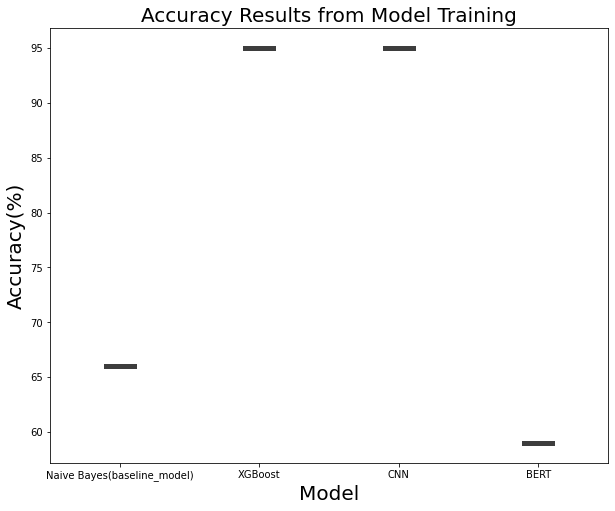

In [113]:
#Visualize the result
plt.figure(figsize=(10,8))
sns.boxplot(data = final_accuracy, x = 'model', y = 'accuracy(%)', width=0.2, linewidth = 5)
plt.title('Accuracy Results from Model Training', fontdict={'size':20})
plt.xlabel( 'Model', fontdict= {'size':20})
plt.ylabel ('Accuracy(%)', fontdict= {'size':20})
plt.show()

The results produced by CNN and XGboost after testing on new data set that has been held out is also shown

In [114]:
new_data_accuracy =  {'model':['XGBoost','CNN'], 
            
            'accuracy(%)':[ xg_test_accuracy, cnn_test_accuracy ] }

new_data_accuracy_df = pd.DataFrame(new_data_accuracy)
new_data_accuracy_df

,model,accuracy(%)
0,XGBoost,73
1,CNN,58


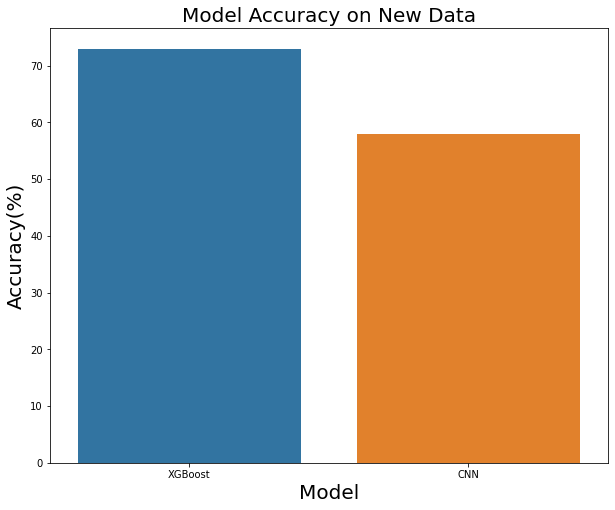

In [115]:
#Visualize the result
plt.figure(figsize=(10,8))
sns.barplot(data = new_data_accuracy_df, y = 'accuracy(%)', x = 'model')
plt.xlabel( 'Model', fontdict= {'size':20})
plt.ylabel ('Accuracy(%)', fontdict= {'size':20})
plt.title('Model Accuracy on New Data', fontdict= {'size':20} )
plt.show()

In [116]:
print ('the accuracy result  of the LDA model is:', lda_accuracy)

the accuracy result  of the LDA model is: 30


The accuracy can be improved by performing text summarization on the scripts before passing them through the topic models.

Other topic modeling approach can also be explored

Availabilty of more data across all target labels will also improve the accuracies rather than pefroming text augmentation